In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('IPN31152N.csv',index_col='DATE',parse_dates=True)

<Axes: xlabel='DATE'>

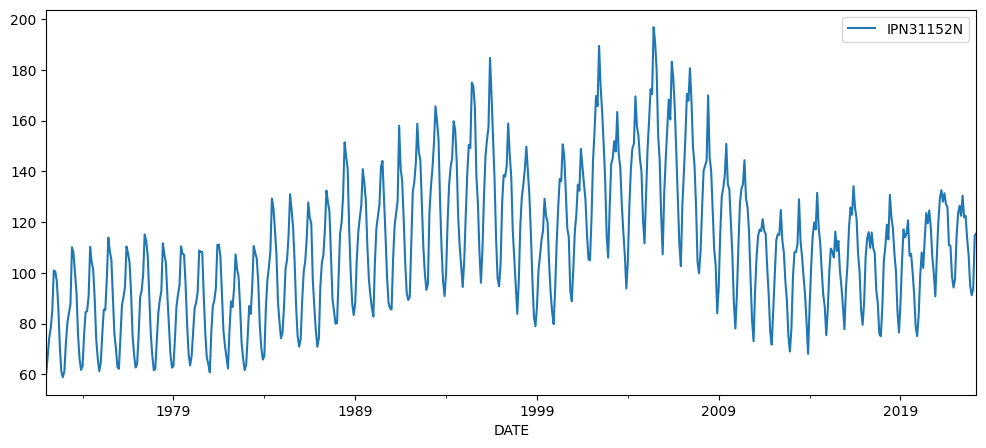

In [3]:
df.plot(figsize=(12,5))

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335


In [5]:
df.columns = ['Production']

## Répartition Entraînement / Test

In [6]:
len(df)

615

In [7]:
len(df)-24

591

In [8]:
test_size = 24
test_ind = len(df)-test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Mise à l'échelle des données

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [15]:
scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

## Générateur de séries temporelles

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 18
generator = TimeseriesGenerator(scaler_train, scaler_train, length=length, batch_size=1)

In [18]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [19]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.00946844 0.06107885 0.11324444 0.14143379 0.18979649 0.30491157
 0.30149644 0.27411739 0.19733776 0.08531384 0.0156138  0.
 0.01773956 0.09849312 0.15587563 0.18355909 0.20875512 0.37144363]
Cela prédit ce y : 
 [[0.35419836]]


In [20]:
scaler_train

array([[0.00946844],
       [0.06107885],
       [0.11324444],
       [0.14143379],
       [0.18979649],
       [0.30491157],
       [0.30149644],
       [0.27411739],
       [0.19733776],
       [0.08531384],
       [0.0156138 ],
       [0.        ],
       [0.01773956],
       [0.09849312],
       [0.15587563],
       [0.18355909],
       [0.20875512],
       [0.37144363],
       [0.35419836],
       [0.29812914],
       [0.23970223],
       [0.12102706],
       [0.05289471],
       [0.02087566],
       [0.03141387],
       [0.12131987],
       [0.18620451],
       [0.18853176],
       [0.23180437],
       [0.37259312],
       [0.32887912],
       [0.30805709],
       [0.22407684],
       [0.10933284],
       [0.05452473],
       [0.01750039],
       [0.04077214],
       [0.12185258],
       [0.19275429],
       [0.19219042],
       [0.28135425],
       [0.39892125],
       [0.35979941],
       [0.33565213],
       [0.22869872],
       [0.1240182 ],
       [0.08401142],
       [0.029

## Création du Modèle

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [22]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [23]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation

REMARQUE : la taille de l'ensemble de données scaled_test DOIT être supérieure à la longueur choisie pour vos batchs. Regardez la vidéo pour plus d'informations à ce sujet.

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
length = 17
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [26]:
validation_generator = TimeseriesGenerator(scaler_test,scaler_test, length=length, batch_size=1)

In [27]:
# ajustement du modèle
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
573/573 [==============================] - 5s 9ms/step - loss: 0.0032 - val_loss: 0.0083
Epoch 2/20
573/573 [==============================] - 5s 8ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 3/20
573/573 [==============================] - 5s 9ms/step - loss: 0.0029 - val_loss: 0.0064
Epoch 4/20
573/573 [==============================] - 4s 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/20
573/573 [==============================] - 4s 8ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 6/20
573/573 [==============================] - 5s 8ms/step - loss: 0.0026 - val_loss: 0.0029


In [28]:
losses = pd.DataFrame(model.history.history)

<Axes: >

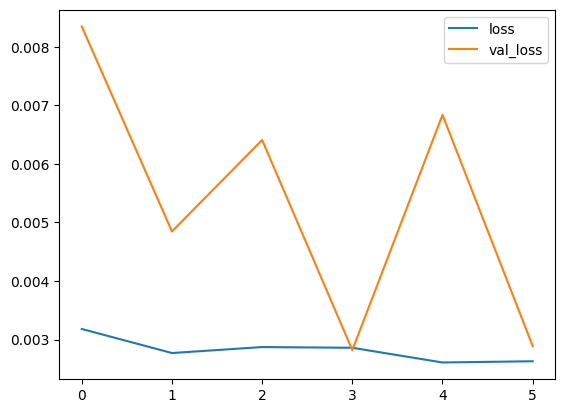

In [29]:
losses.plot()

## Évaluation sur les données de test

In [53]:
# Pensons au premier point batch que je devrai passer dans mon modèle pour prédire quelque chose sur le set de test

first_eval_batch = scaler_train[-length:] #on prend les 50 derniers points de train pour predire le premier point de test

In [54]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) #on reshape pour que le modèle puisse le lire

In [55]:
model.predict(first_eval_batch) #on predit le premier point de test

ValueError: in user code:

    File "C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 18, 1), found shape=(None, 17, 1)


In [30]:
scaler_test[0] #on compare avec le premier point de test

array([0.37557194])

In [31]:
#boucle pour predire tous les points de test
test_predictions = []
first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [32]:
first_eval_batch

array([[0.34471035],
       [0.29659262],
       [0.23086797],
       [0.34511622],
       [0.44446965],
       [0.51066033],
       [0.5342394 ],
       [0.50161951],
       [0.52567547],
       [0.49443555],
       [0.48659495],
       [0.37762087]])

In [33]:
predicted_value = [[[38]]] #on initialise predicted_value
np.append(current_batch[:,1:,:],[[[38]]],axis=1) #on prend le dernier point de current_batch et on lui ajoute le point suivant de scaled_train

array([[[ 0.29659262],
        [ 0.23086797],
        [ 0.34511622],
        [ 0.44446965],
        [ 0.51066033],
        [ 0.5342394 ],
        [ 0.50161951],
        [ 0.52567547],
        [ 0.49443555],
        [ 0.48659495],
        [ 0.37762087],
        [38.        ]]])

In [34]:
test_predictions = []

first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 35ms/step


## Transformations inverses et Comparaison

In [35]:
test_predictions

[array([0.32374752], dtype=float32),
 array([0.2598617], dtype=float32),
 array([0.2703598], dtype=float32),
 array([0.34079587], dtype=float32),
 array([0.41785133], dtype=float32),
 array([0.47642395], dtype=float32),
 array([0.50574654], dtype=float32),
 array([0.5261787], dtype=float32),
 array([0.5311728], dtype=float32),
 array([0.5178156], dtype=float32),
 array([0.463185], dtype=float32),
 array([0.3827428], dtype=float32),
 array([0.3049184], dtype=float32),
 array([0.25806308], dtype=float32),
 array([0.27280304], dtype=float32),
 array([0.3277721], dtype=float32),
 array([0.39488423], dtype=float32),
 array([0.45232823], dtype=float32)]

In [36]:
scaler_test

array([[0.37557194],
       [0.28772429],
       [0.25639522],
       [0.28046496],
       [0.40039616],
       [0.46663323],
       [0.48980859],
       [0.46119235],
       [0.5187633 ],
       [0.45688212],
       [0.46089302],
       [0.39620335],
       [0.34758553],
       [0.26176869],
       [0.23401204],
       [0.25289094],
       [0.40440996],
       [0.41102859]])

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
true_predictions

array([[103.5152721 ],
       [ 94.70068524],
       [ 96.14915204],
       [105.86750408],
       [116.49916103],
       [124.58066558],
       [128.62642415],
       [131.445535  ],
       [132.13459068],
       [130.29163998],
       [122.75403521],
       [111.65509231],
       [100.91734297],
       [ 94.45252092],
       [ 96.48625369],
       [104.07056198],
       [113.33029606],
       [121.25608112]])

In [39]:
test['Predictions'] = true_predictions

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6364\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [40]:
test

,Sales,Predictions
DATE,,
2021-10-01,110.6657,103.515272
2021-11-01,98.5450,94.700685
2021-12-01,94.2224,96.149152
2022-01-01,97.5434,105.867504
2022-02-01,114.0908,116.499161
2022-03-01,123.2298,124.580666
2022-04-01,126.4274,128.626424
2022-05-01,122.4791,131.445535
2022-06-01,130.4224,132.134591


<Axes: xlabel='DATE'>

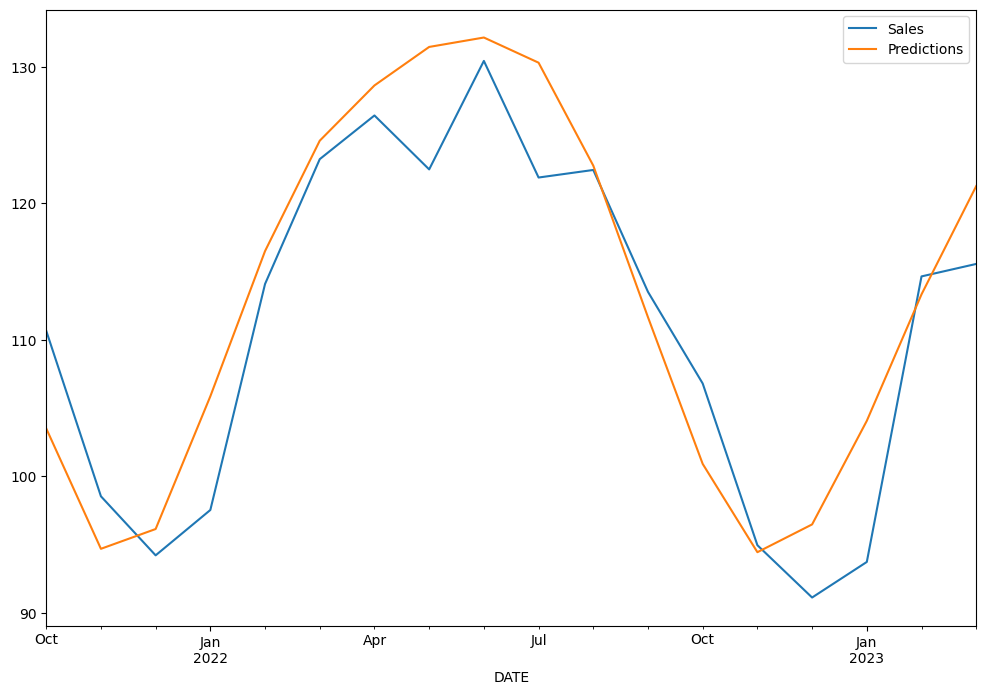

In [41]:
test.plot(figsize=(12,8))

## Ré-Entraînement et Prévision